<a href="https://colab.research.google.com/github/navneedh/compression-ml/blob/master/train_cifar_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab_ssh --upgrade
from colab_ssh import launch_ssh
ngrokToken = "1oJKoifyXwVKlHiSCSND1yNvfp9_MXUSSb5W4Db4YbZDLHJS"
launch_ssh(ngrokToken, password="password")

we highly recommend that update your code by following this documentation https://github.com/WassimBenzarti/colab-ssh#getting-started
Successfully running 4.tcp.ngrok.io:17531
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

	Host google_colab_ssh
		HostName 4.tcp.ngrok.io
		User root
		Port 17531
	  


In [ ]:
from google.colab import drive
root = "/content/drive/MyDrive/"
drive.mount('/content/drive/')

# sudo apt-get install imagemagick
# find . -name '*.JPEG' -type f -exec bash -c 'convert "$0" "${0%.JPEG}.png"' {} \;

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/compression-ml/

/content/drive/MyDrive/compression-ml


In [ ]:
!ls -a

cifar_models			.gitignore
compare_degradation.ipynb	model_red.png
compression_models		m_utils
data				ngrok
dataaug_maxmodel.png		ngrok-stable-linux-amd64.zip
data_to_np.py			README.md
embedding_visualizations.ipynb	saved_models
exp_results			train.ipynb
.git


In [ ]:
%reload_ext autoreload
%autoreload 2

from fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from m_utils.compression_compare import *
import matplotlib.pyplot as plt
 
from cifar_models import *
from m_utils.dataset import *
from m_utils.image_utils import *
from cifar_models.vgg import *
from cifar_models.resnet import *
device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [ ]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

BATCH_SIZE = 128
EPOCHS = 30

In [ ]:
exp_name = "res18_bls012"
train_dset = CifarDataset("_bls_012", train = True, transform = transform_train)
test_dset = CifarDataset("", train = False, transform = transform_test)

# train_dset.filter([5])
# test_dset.filter([5])

# Torchvision CIFAR data
# train_dset = torchvision.datasets.CIFAR10(
#     root="~/Workspace/data", train=True, download=True, transform=transform
# )

# test_dset = torchvision.datasets.CIFAR10(
#     root="~/Workspace/data", train=False, download=True, transform=transform
# )

train_loader = DataLoader(train_dset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
len(train_dset)

50000

In [ ]:
# net = ().to(device)
# net = VGG('VGG11s7').to(device)
net = ResNet18([1,0,0,0]).to(device)
print(pytorch_count_params(net))
print(net)

116810
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
def train(trainloader):
    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    accuracy = []
    losses = []
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return correct/total, train_loss/(50000/BATCH_SIZE) 

def test(testloader):
    softmax_output = nn.Softmax()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    metrics = []
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return correct/total, test_loss/(10000/BATCH_SIZE) 
    
RUNS = 3

all_train_acc = []
all_test_acc = []
max_test_acc = 0
for run in progress_bar(range(RUNS)):
  train_acc, train_loss, test_acc, test_loss = [], [], [], []
  # net = VGG('VGG11s8').to(device)
  net = ResNet18([2,2,2,2]).to(device)
  max_test_acc = 0
  for epoch in progress_bar(range(EPOCHS)):    
      train_a, train_l = train(train_loader)
      test_a, test_l = test(test_loader)
      
      if test_a > max_test_acc:
        max_test_acc = test_a 
        model_state = net.state_dict()
        print(test_a)

      train_acc.append(train_a)
      train_loss.append(train_l)
      test_acc.append(test_a)
      test_loss.append(test_l)
  print("Train Accuracy: {}, Test Accuracy: {}".format(train_a, test_a))
  all_train_acc.append(train_acc)
  all_test_acc.append(test_acc)
     
# exp_name = exp_name.replace("_","")
# np.savez("/content/drive/MyDrive/compression-ml/exp_results/{}.npz".format(exp_name), train_acc=all_train_acc, train_loss=train_loss, test_acc=all_test_acc, test_loss=test_loss)
np.savez("/content/drive/MyDrive/compression-ml/exp_results/model_compression_results/{}.npz".format(exp_name), train_acc=all_train_acc, train_loss=train_loss, test_acc=all_test_acc, test_loss=test_loss)
# torch.save(model_state, "/content/drive/MyDrive/compression-ml/saved_models/{}.pt".format(exp_name))

0.4071
0.4908
0.5821
0.6259
0.6694
0.7059
0.7535
0.7603
0.7933
0.8129
0.8174
Train Accuracy: 0.82662, Test Accuracy: 0.8097


0.4388
0.5385
0.6365
0.6761
0.7216
0.7238
0.7283
0.7432
0.7561
0.7575
0.7867
0.7956
0.818
0.8309
Train Accuracy: 0.82572, Test Accuracy: 0.8014


0.4053
0.5313
0.6016
0.6631
0.6972
0.7296
0.7318
0.7436
0.7848
0.7967
0.8057
0.8134
0.821
Train Accuracy: 0.82468, Test Accuracy: 0.818


In [ ]:
exp_name

'vgg11s7_base'

In [ ]:
exp_results_folder = "exp_results/model_compression_results/" 
base_res18s4 = np.load(exp_results_folder + "vgg11s5_base.npz")
base_res18s4['test_acc'].max()

0.8029

## Clean Accuracy Results (Resnet18)

In [ ]:
exp_results_folder = "exp_results/model_compression_results/"

res18_base = np.load(exp_results_folder + "res18_base.npz")
res18_bls1 = np.load(exp_results_folder + "res18_bls1.npz")
res18_bls05 = np.load(exp_results_folder + "res18_bls05.npz")
res18_bls033 = np.load(exp_results_folder + "res18_bls033.npz")
res18_bls012 = np.load(exp_results_folder + "res18_bls012.npz")
res18_bls005 = np.load(exp_results_folder + "res18_bls005.npz")
res18_bls003 = np.load(exp_results_folder + "res18_bls003.npz")
res18_bls001 = np.load(exp_results_folder + "res18_bls001.npz")

res18_jpeg60 = np.load(exp_results_folder + "res18_jpeg60.npz")
res18_jpeg40 = np.load(exp_results_folder + "res18_jpeg40.npz")
res18_jpeg20 = np.load(exp_results_folder + "res18_jpeg20.npz")
res18_jpeg10 = np.load(exp_results_folder + "res18_jpeg10.npz")
res18_jpeg5 = np.load(exp_results_folder + "res18_jpeg5.npz")
res18_jpeg1 = np.load(exp_results_folder + "res18_jpeg1.npz")

exp_results_folder = "exp_results/"

vgg11_base = np.load(exp_results_folder + "base.npz")
vgg11_bls001 = np.load(exp_results_folder + "bls001.npz")
vgg11_bls003 = np.load(exp_results_folder + "bls003.npz")
vgg11_bls005 = np.load(exp_results_folder + "bls005.npz")
vgg11_bls012 = np.load(exp_results_folder + "bls012.npz")
vgg11_bls033 = np.load(exp_results_folder + "bls033.npz")
vgg11_bls05 = np.load(exp_results_folder + "bls05.npz")
vgg11_bls1 = np.load(exp_results_folder + "bls1.npz")

vgg11_jpeg1 = np.load(exp_results_folder + "jpeg1.npz")
vgg11_jpeg5 = np.load(exp_results_folder + "jpeg5.npz")
vgg11_jpeg10 = np.load(exp_results_folder + "jpeg10.npz")
vgg11_jpeg20 = np.load(exp_results_folder + "jpeg20.npz")
vgg11_jpeg40 = np.load(exp_results_folder + "jpeg40.npz")
vgg11_jpeg60 = np.load(exp_results_folder + "jpeg60.npz")

res18_bls_res = [res18_bls001, res18_bls003, res18_bls005, res18_bls012, res18_bls033, res18_bls05, res18_bls1]
res18_jpeg_res = [res18_jpeg1, res18_jpeg5, res18_jpeg10, res18_jpeg20, res18_jpeg40, res18_jpeg60]

vgg11_bls_res = [vgg11_bls001, vgg11_bls003, vgg11_bls005, vgg11_bls012, vgg11_bls033, vgg11_bls05, vgg11_bls1]
vgg11_jpeg_res = [vgg11_jpeg1, vgg11_jpeg5, vgg11_jpeg10, vgg11_jpeg20, vgg11_jpeg40, vgg11_jpeg60]

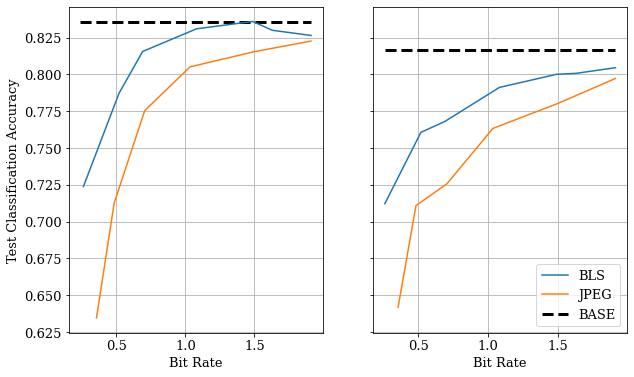

In [ ]:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,6))
axs[0].set_ylabel("Test Classification Accuracy")
axs[0].set_xlabel("Bit Rate")
axs[1].set_xlabel("Bit Rate")

axs[0].plot([0.2612, 0.519, 0.69, 1.08, 1.48712, 1.63, 1.91], [res["test_acc"].max() for res in res18_bls_res], label = "BLS")
axs[0].plot([0.3559, 0.484, 0.7054, 1.034, 1.50, 1.91], [res["test_acc"].max() for res in res18_jpeg_res], label = "JPEG")
axs[1].plot([0.2612, 0.519, 0.69, 1.08, 1.48712, 1.63, 1.91], [res["test_acc"].max() for res in vgg11_bls_res], label = "BLS")
axs[1].plot([0.3559, 0.484, 0.7054, 1.034, 1.50, 1.91], [res["test_acc"].max() for res in vgg11_jpeg_res], label = "JPEG")
axs[1].hlines(vgg11_base["test_acc"].max(), 0.2612, 1.91, linestyles = "dashed", linewidth = 3, label = "BASE")
axs[0].hlines(res18_base["test_acc"].max(), 0.24, 1.91, linestyles = "dashed", linewidth = 3, label = "BASE")
axs[1].legend(loc = 4)
axs[0].grid()
axs[1].grid()
plt.show()


In [ ]:
 [res["test_acc"].max() for res in res18_bls_res]

[0.7238, 0.7871, 0.8155, 0.8309, 0.8359, 0.8299, 0.8264]

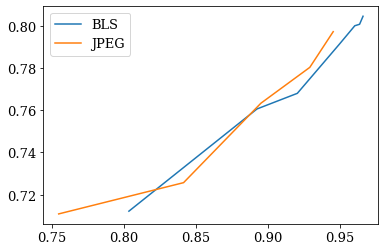

In [ ]:
bls_ssim = [0.8033611755066715, 0.8925222112445196, 0.9206221111020455, 0.9496784357041587, 0.9606196472540803, 0.9639560478472449, 0.9663533633433264]
jpeg_ssim = [0.6282734028726298, 0.7544690408452686, 0.8414159296752199, 0.8952277393712936, 0.9293016265473689, 0.9455897175998793]

bls_vals = (np.array([res["test_acc"].max() for res in res18_bls_res]) + np.array([res["test_acc"].max() for res in vgg11_bls_res]))/2
jpeg_vals = (np.array([res["test_acc"].max() for res in res18_jpeg_res]) + np.array([res["test_acc"].max() for res in vgg11_jpeg_res]))/2


plt.plot(bls_ssim, [res["test_acc"].max() for res in vgg11_bls_res], label = "BLS")
plt.plot(jpeg_ssim[1:], [res["test_acc"].max()  for res in vgg11_jpeg_res[1:]], label= "JPEG")

plt.legend()

### SSIM Distortion vs Classification Accuracy

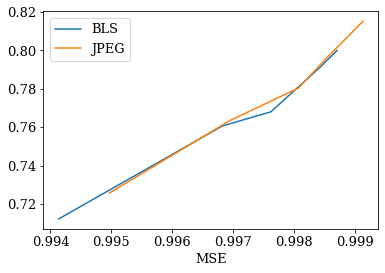

In [ ]:
bls_mse = [0.9941349601460377, 0.9968172396123686, 0.9976149595443059, 0.9984171211007586, 0.9987018717210129, 0.9987740578828856, 0.9988235362040241]
jpeg_mse = [0.9856658684675565, 0.9913320319213164, 0.9949674948582476, 0.9969346679246964, 0.9980626119641486, 0.9985651426149198, 0.9991264399549853]

plt.xlabel("MSE")
plt.plot(bls_mse[:5], [bls1["test_acc"].max(), bls3["test_acc"].max(), bls5["test_acc"].max(),bls12["test_acc"].max(),bls33["test_acc"].max()], label = "BLS")
plt.plot(jpeg_mse[2:], [jpeg10["test_acc"].max(), jpeg20["test_acc"].max(), jpeg40["test_acc"].max(),jpeg60["test_acc"].max(), jpeg80["test_acc"].max()], label= "JPEG")
plt.legend()

NameError: ignored

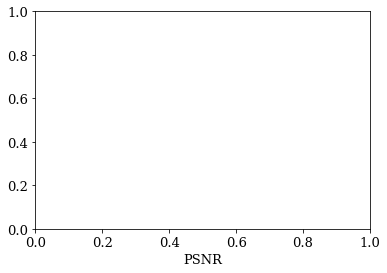

In [ ]:
bls_psnr = [70.79729360853239, 73.4946560640531, 74.79034571820387, 76.68966325217183, 77.74087980823379, 78.09331479772197, 78.36313089528345]
jpeg_psnr = [66.77749201889438, 69.00128812822874, 71.41538589853432, 73.63346919222693, 75.70015984217537, 77.05283569886534, 79.27092744609718]


plt.xlabel("PSNR")
plt.plot(bls_psnr[:5], [bls1["test_acc"].max(), bls3["test_acc"].max(), bls5["test_acc"].max(),bls12["test_acc"].max(),bls33["test_acc"].max()], label = "BLS")
plt.plot(jpeg_psnr[1:], [jpeg5["test_acc"].max(), jpeg10["test_acc"].max(), jpeg20["test_acc"].max(), jpeg40["test_acc"].max(),jpeg60["test_acc"].max(), jpeg80["test_acc"].max()], label= "JPEG")
plt.legend()